In [30]:
import numpy as np
import pylab
import matplotlib.pyplot as plt

In [26]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = max(sum(P),1e-13)
    sumP = min(sumP,1e13)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

In [6]:
if __name__ == "__main__":
    X_20_c = np.loadtxt("spinConfigs_Ising_L20.txt")
    X_40_c = np.loadtxt("spinConfigs_Ising_L40.txt")
    X_80_c = np.loadtxt("spinConfigs_Ising_L80.txt")
    labels_20_c = np.loadtxt("temperatures_Ising_L20.txt")
    labels_40_c = np.loadtxt("temperatures_Ising_L40.txt")
    labels_80_c = np.loadtxt("temperatures_Ising_L80.txt")
    X_20_g = np.loadtxt("spinConfigs_gaugeTheory_L20.txt")
    X_40_g = np.loadtxt("spinConfigs_gaugeTheory_L40.txt")
    labels_20_g = np.loadtxt("labels_gaugeTheory_L20.txt")
    labels_40_g = np.loadtxt("labels_gaugeTheory_L40.txt")

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 1.894097
Iteration 10: error is 15.285544
Iteration 20: error is 13.306829
Iteration 30: error is 12.662797
Iteration 40: error is 12.627057
Iteration 50: error is 12.671990
Iteration 60: error is 12.719269
Iteration 70: error is 12.731930
Iteration 80: error is 12.729349
Iteration 90: error is 12.724758
Iteration 100: error is 12.722721
Iteration 110: error is 1.653718
Iteration 120: error is 1.420093
Iteration 130: error is 1.298936
Iteration 140: error is 1.235220
Iteration 150: error is 1.195364
Iteration 160: error is 1.170078
Iteration 170: error is 1.153255
Iteration 180: error is 1.142023
Iteration 190: error is 1.133979
Iteration 200: error is 1.127867
Iteration 210: error is 1.123202
Iteration 220: error is 1.119397

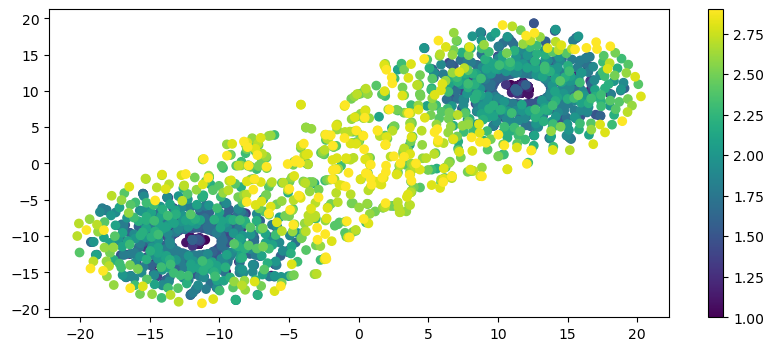

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 1.894097
Iteration 10: error is 15.102957
Iteration 20: error is 13.193820
Iteration 30: error is 12.675315
Iteration 40: error is 12.645383
Iteration 50: error is 12.682484
Iteration 60: error is 12.718978
Iteration 70: error is 12.729395
Iteration 80: error is 12.727993
Iteration 90: error is 12.724873
Iteration 100: error is 12.723185
Iteration 110: error is 1.651052
Iteration 120: error is 1.414013
Iteration 130: error is 1.295704
Iteration 140: error is 1.232701
Iteration 150: error is 1.193972
Iteration 160: error is 1.168412
Iteration 170: error is 1.151188
Iteration 180: error is 1.139714
Iteration 190: error is 1.131381
Iteration 200: error is 1.125031
Iteration 210: error is 1.120078
Iteration 220: error is 1.116630

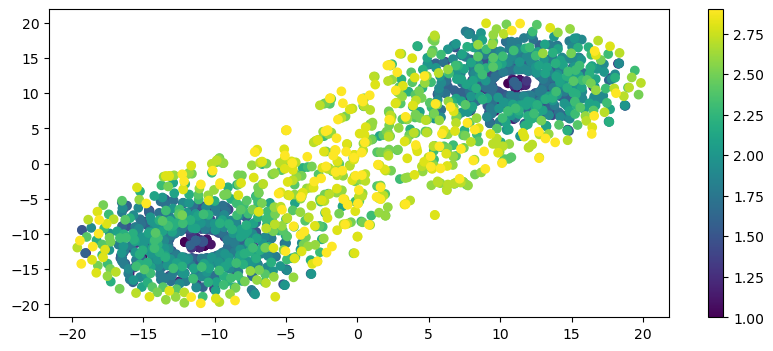

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 4.008212
Iteration 10: error is 14.148843
Iteration 20: error is 12.235434
Iteration 30: error is 11.916365
Iteration 40: error is 11.904608
Iteration 50: error is 11.940935
Iteration 60: error is 12.044126
Iteration 70: error is 11.910990
Iteration 80: error is 12.087426
Iteration 90: error is 12.046205
Iteration 100: error is 12.071690
Iteration 110: error is 1.549882
Iteration 120: error is 1.349848
Iteration 130: error is 1.259961
Iteration 140: error is 1.222881
Iteration 150: error is 1.210423
Iteration 160: error is 1.202912
Iteration 170: error is 1.198154
Iteration 180: error is 1.195074
Iteration 190: error is 1.193057
Iteration 200: error is 1.191722
Iteration 210: error is 1.190770
Iteration 220: error is 1.190051

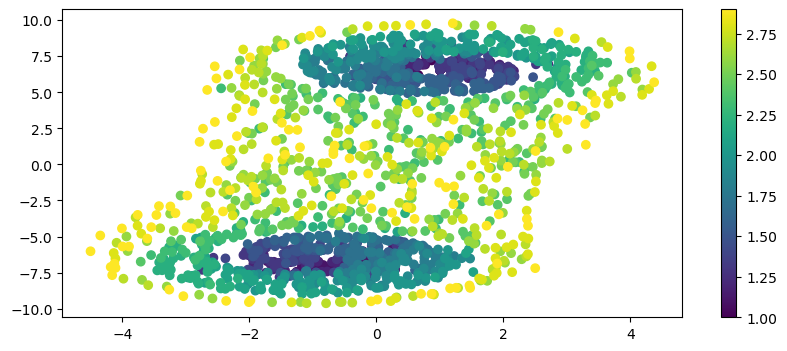

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 8.457646
Iteration 10: error is 14.226002
Iteration 20: error is 12.989931
Iteration 30: error is 14.358314
Iteration 40: error is 14.721255
Iteration 50: error is 16.018984
Iteration 60: error is 15.827583
Iteration 70: error is 16.901204
Iteration 80: error is 16.483322
Iteration 90: error is 16.794406
Iteration 100: error is 16.480241
Iteration 110: error is 2.571652
Iteration 120: error is 2.324009
Iteration 130: error is 2.115833
Iteration 140: error is 1.951646
Iteration 150: error is 1.813924
Iteration 160: error is 1.686480
Iteration 170: error is 1.602279
Iteration 180: error is 1.379543
Iteration 190: error is 1.365369
Iteration 200: error is 1.316570
Iteration 210: error is 1.200890
Iteration 220: error is 1.149495

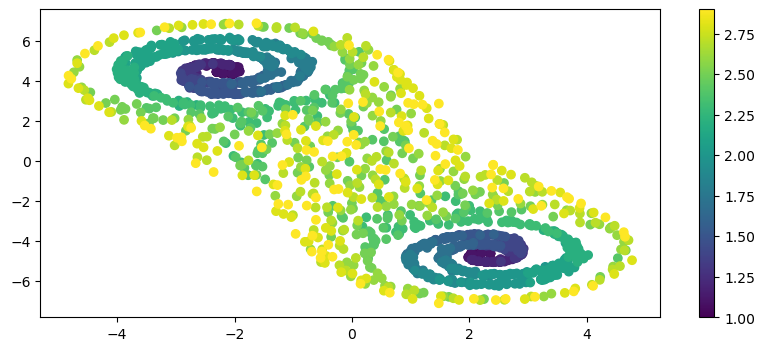

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 6.503270
Iteration 10: error is 9.144946
Iteration 20: error is 9.144515
Iteration 30: error is 9.144511
Iteration 40: error is 9.144510
Iteration 50: error is 9.144510
Iteration 60: error is 9.144510
Iteration 70: error is 9.144510
Iteration 80: error is 9.144510
Iteration 90: error is 9.144510
Iteration 100: error is 9.144510
Iteration 110: error is 0.899833
Iteration 120: error is 0.899832
Iteration 130: error is 0.892404
Iteration 140: error is 0.882878
Iteration 150: error is 0.880988
Iteration 160: error is 0.880331
Iteration 170: error is 0.880009
Iteration 180: error is 0.879773
Iteration 190: error is 0.879543
Iteration 200: error is 0.879335
Iteration 210: error is 0.879171
Iteration 220: error is 0.879063
Iteration 230: error is 0.878998
Iteration 240: error is 0.878946
Iteration 250: error is 0.878901


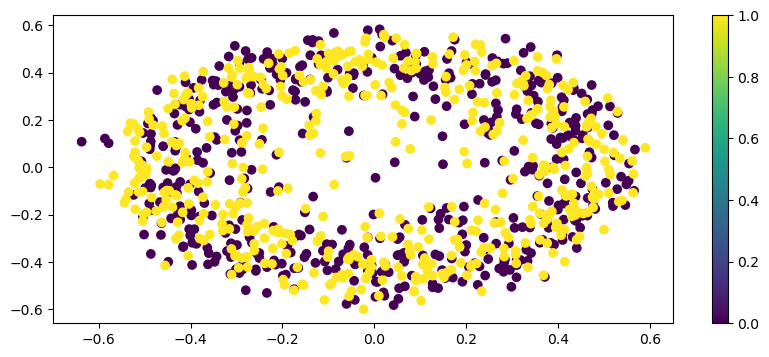

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 13.122383
Iteration 10: error is 6.405079
Iteration 20: error is 6.404349
Iteration 30: error is 6.404348
Iteration 40: error is 6.404348
Iteration 50: error is 6.404348
Iteration 60: error is 6.404348
Iteration 70: error is 6.404348
Iteration 80: error is 6.404348
Iteration 90: error is 6.404348
Iteration 100: error is 6.404348
Iteration 110: error is 0.214793
Iteration 120: error is 0.214793
Iteration 130: error is 0.214792
Iteration 140: error is 0.214676
Iteration 150: error is 0.213190
Iteration 160: error is 0.212676
Iteration 170: error is 0.212537
Iteration 180: error is 0.212481
Iteration 190: error is 0.212445
Iteration 200: error is 0.212417
Iteration 210: error is 0.212400
Iteration 220: error is 0.212387
Iteration 230: error is 0.212376
Iteration 240: error is 0.212368
Iteration 250: error is 0.212363

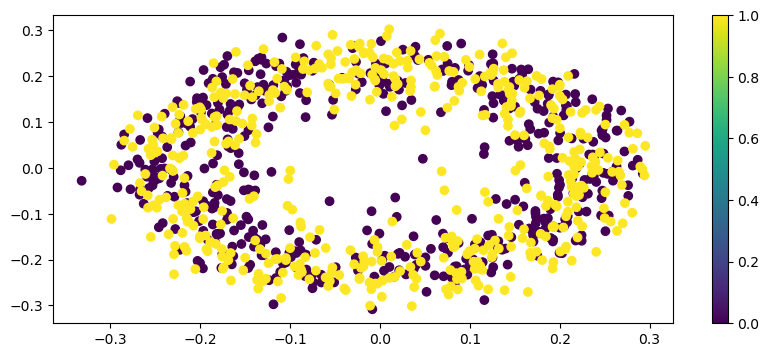

In [40]:
if __name__ == "__main__":    
    Y_20_c = tsne(X_20_c, 2,20**2, 20.0)
    fig = plt.figure(1,figsize=(10,4))
    plt.scatter(Y_20_c[:, 0],Y_20_c[:, 1],c=labels_20_c)
    plt.colorbar()
    plt.savefig('L20.png', bbox_inches="tight")
    plt.show()
    plt.close()
    Y_20_c1 = tsne(X_20_c, 2,20**2, 20.0)
    fig = plt.figure(2,figsize=(10,4))
    plt.scatter(Y_20_c1[:, 0],Y_20_c1[:, 1],c=labels_20_c)
    plt.colorbar()
    plt.savefig('L201.png', bbox_inches="tight")
    plt.show()
    plt.close()
    Y_40_c = tsne(X_40_c, 2,40**2, 20.0)
    fig = plt.figure(3,figsize=(10,4))
    plt.scatter(Y_40_c[:, 0],Y_40_c[:, 1],c=labels_40_c)
    plt.colorbar()
    plt.savefig('L40.png', bbox_inches="tight")
    plt.show()
    plt.close()
    Y_80_c = tsne(X_80_c, 2,80**2, 20.0)
    fig = plt.figure(4,figsize=(10,4))
    plt.scatter(Y_80_c[:, 0],Y_80_c[:, 1],c=labels_80_c)
    plt.colorbar()
    plt.savefig('L80.png', bbox_inches="tight")
    plt.show()
    plt.close()
    Y_20_g = tsne(X_20_g, 2,2*20**2, 20.0)
    fig = plt.figure(5,figsize=(10,4))
    plt.scatter(Y_20_g[:, 0],Y_20_g[:, 1],c=labels_20_g)
    plt.colorbar()
    plt.savefig('L20g.png', bbox_inches="tight")
    plt.show()
    plt.close()
    Y_40_g = tsne(X_40_g, 2,2*40**2, 20.0)
    fig = plt.figure(1,figsize=(10,4))
    plt.scatter(Y_40_g[:, 0],Y_40_g[:, 1],c=labels_40_g)
    plt.colorbar()
    plt.savefig('L40g.png', bbox_inches="tight")
    plt.show()
    plt.close()